<a href="https://colab.research.google.com/github/ybii22/Machine-Learning/blob/main/UTS/ClusteringTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Manipulasi data
import pandas as pd
import numpy as np

# 2. Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# 4. Clustering Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

# 5. Evaluasi Clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples

# 6. Hierarchical Clustering (Dendrogram)
from scipy.cluster.hierarchy import dendrogram, linkage


In [2]:
# Pengumpulan dan Pembersihan Data
df = pd.read_csv("/content/UTSClustering.csv", encoding='latin1')

# Ubah kolom tanggal ke format datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Hapus baris dengan CustomerID kosong
df.dropna(subset=['CustomerID'], inplace=True)

# Hapus baris dengan Quantity atau UnitPrice yang tidak valid
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 3. Lihat hasil pembersihan data
print("Informasi Data:")
print(df.info())

print("\nStatistik Deskriptif:")
print(df.describe())

print("\n5 Data Teratas:")
print(df.head())

print(f"\nJumlah baris setelah pembersihan: {df.shape[0]}")


Informasi Data:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB
None

Statistik Deskriptif:
            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0

# **Feature Selection**

Fitur setelah menghapus constant features: ['Quantity', 'UnitPrice', 'TotalPrice']


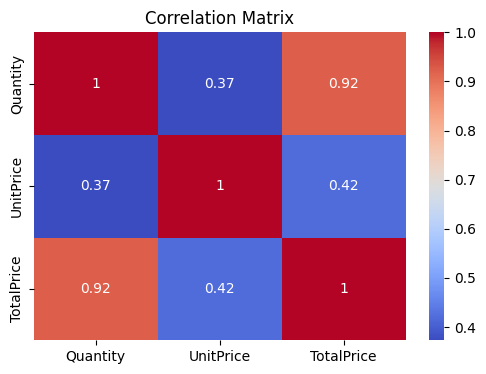

In [3]:
# Salin data agar aman
df_fs = df.copy()

# 1. Pilih fitur numerik yang relevan untuk clustering
#  mengelompokkan pelanggan berdasarkan transaksi mereka
df_fs['TotalPrice'] = df_fs['Quantity'] * df_fs['UnitPrice']
selected_features = ['CustomerID', 'Quantity', 'UnitPrice', 'TotalPrice']

# 2. Agregasi per Customer (karena clustering biasanya dilakukan per customer)
df_grouped = df_fs.groupby('CustomerID')[selected_features[1:]].sum()

# 3. Hapus fitur dengan variansi nol (constant features)
variances = df_grouped.var()
constant_features = variances[variances == 0].index.tolist()
df_grouped.drop(columns=constant_features, inplace=True)

print("Fitur setelah menghapus constant features:", df_grouped.columns.tolist())

# 4. Cek korelasi antar fitur
plt.figure(figsize=(6,4))
sns.heatmap(df_grouped.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 5. Simpan hasil untuk feature engineering selanjutnya
X_features = df_grouped.copy()


# **Feature Engineering**

In [4]:
#  Copy data hasil feature selection
X = X_features.copy()

#  Log Transformation (mengatasi skewness / distribusi miring)
# Hindari log(0) dengan +1 jika ada nilai kecil
X_log = np.log1p(X)

#  Standarisasi (mean = 0, std = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

#  (Opsional) Reduksi Dimensi untuk Visualisasi dan Percepatan
# PCA untuk mengurangi ke 2 komponen (bisa untuk scatter plot nantinya)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Tampilkan hasil PCA
print("Hasil PCA (2 Komponen):")
print(X_pca[:5])  # Tampilkan 5 data pertama


Hasil PCA (2 Komponen):
[[ 2.86209635 -5.30625565]
 [ 2.19268587 -0.15500629]
 [ 1.35298855 -0.59319086]
 [ 1.26990457  0.66275471]
 [-0.91298983  0.03737382]]


# **Model KMeans**

KMeans Clustering:
Silhouette Score: 0.378
Davies-Bouldin Index: 0.866
Calinski-Harabasz Score: 4643.717


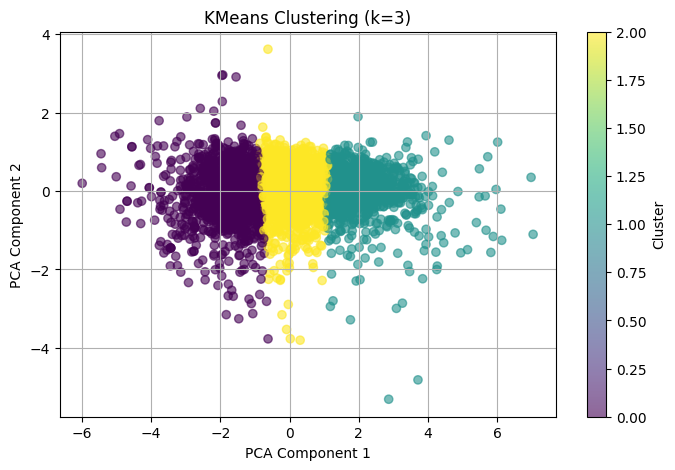

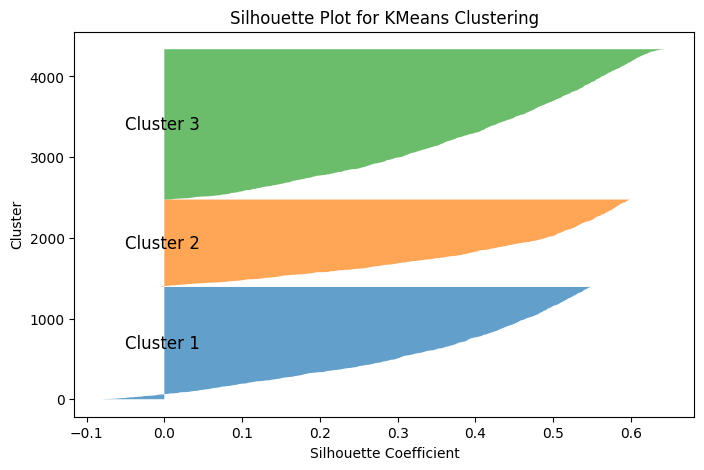

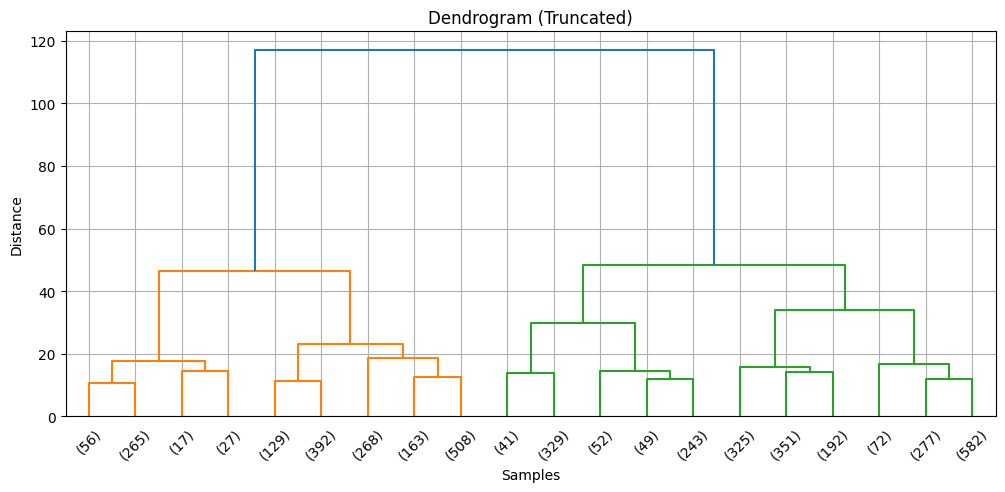

In [8]:
# 1. Buat model KMeans (misal k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 2. Evaluasi Model
sil_score = silhouette_score(X_scaled, kmeans_labels)
db_score = davies_bouldin_score(X_scaled, kmeans_labels)
ch_score = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"KMeans Clustering:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# 3. Visualisasi Scatter Plot (PCA 2D)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 4. Visualisasi Silhouette Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Hitung silhouette score untuk setiap sampel
silhouette_vals = silhouette_samples(X_scaled, kmeans_labels)

# Urutkan berdasarkan nilai silhouette
y_lower, y_upper = 0, 0
for i in range(k):  # Untuk k=3 klaster
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()

    y_upper = y_lower + len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {i+1}', fontsize=12, verticalalignment='center')

    y_lower = y_upper

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for KMeans Clustering')
plt.show()

# 5. Visualisasi Dendrogram (Opsional)
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrogram (Truncated)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# 6. Tambahkan label cluster ke dataframe
X_features['Cluster_KMeans'] = kmeans_labels

### **Penjelasan model KMeans**

KMeans adalah salah satu algoritma clustering yang paling populer dan sederhana.

**Silhouette Score** (0.378): Menunjukkan seberapa baik sampel berada dalam klaster mereka. Nilai lebih tinggi berarti pemisahan klaster lebih baik.

**Davies-Bouldin Index** (0.866): Semakin rendah, semakin baik. Nilai ini menunjukkan klaster yang cukup terpisah.

**Calinski-Harabasz Score** (4643.717): Semakin tinggi, semakin baik pemisahan antar klaster. Ini yang terbaik di antara ketiganya.

Matrik terbaik adalah calinski-harabasz score, karena semakin tinggi nilainya, semakin baik pemisah klasternya. KMeans bekerja dengan baik pada data yang memiliki klaster bulat, tetapi model ini masih belum cukup baik untuk data yang lebih kompleks.

# **Model Agglomerative Clustering**

Agglomerative Clustering:
Silhouette Score: 0.331
Davies-Bouldin Index: 1.071
Calinski-Harabasz Score: 3497.738


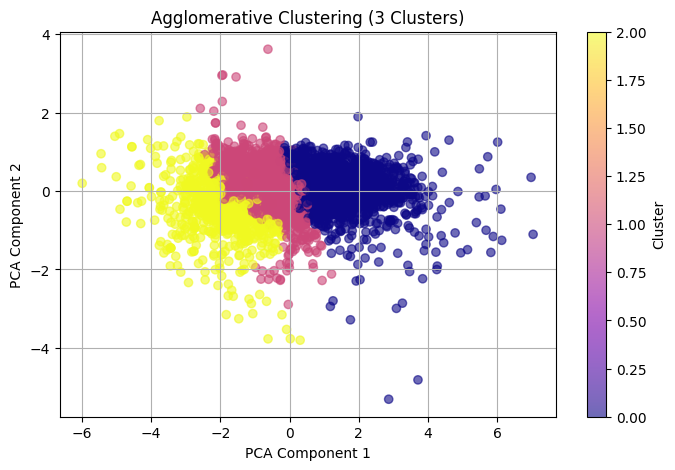

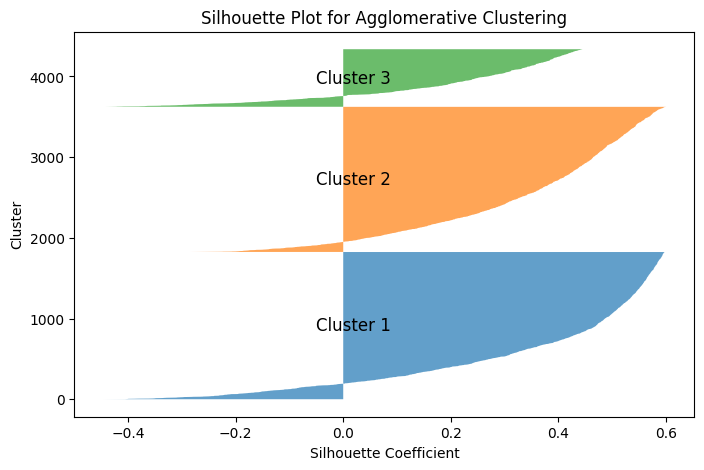

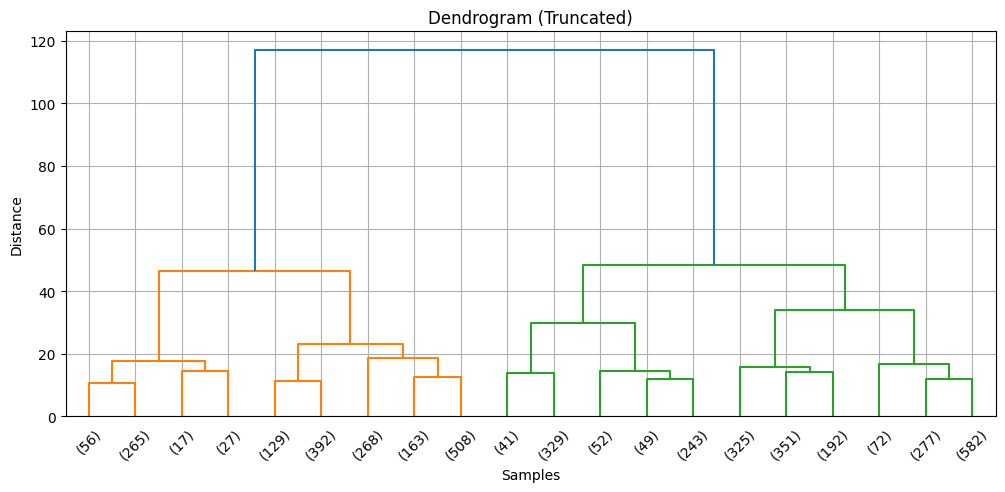

In [7]:
# 1. Buat model Agglomerative Clustering (misal 3 klaster)
agglo_model = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo_model.fit_predict(X_scaled)

# 2. Evaluasi Model
sil_score = silhouette_score(X_scaled, agglo_labels)
db_score = davies_bouldin_score(X_scaled, agglo_labels)
ch_score = calinski_harabasz_score(X_scaled, agglo_labels)

print(f"Agglomerative Clustering:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# 3. Visualisasi Cluster (2D PCA)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='plasma', alpha=0.6)
plt.title('Agglomerative Clustering (3 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 4. Visualisasi Silhouette Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Hitung silhouette score untuk setiap sampel
silhouette_vals = silhouette_samples(X_scaled, agglo_labels)

# Urutkan berdasarkan nilai silhouette
y_lower, y_upper = 0, 0
for i in range(3):  # Untuk 3 klaster
    cluster_silhouette_vals = silhouette_vals[agglo_labels == i]
    cluster_silhouette_vals.sort()

    y_upper = y_lower + len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {i+1}', fontsize=12, verticalalignment='center')

    y_lower = y_upper

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for Agglomerative Clustering')
plt.show()

# 5. (Opsional) Visualisasi Dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrogram (Truncated)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# Tambahkan label cluster ke dataframe
X_features['Cluster_Agglomerative'] = agglo_labels

### **Penjelasan Model Agglomerative Clustering**

Agglomerative clustering adalah algoritma hierarchical clustering yang bekerja dengan menggabungkan data yang paling mirip menjadi klaster, dimulai dengan setiap data sebagai klaster terpisah dan secara bertahap menggabungkannya hingga tercapau jumlah klaster yang diinginkan.

**Silhouette Score** (0.331):
Nilai ini menunjukkan bahwa klaster tidak terpisah dengan jelas. Semakin mendekati 1, semakin baik pemisahan klaster. Nilai 0.331 cukup rendah, menandakan klaster tidak terlalu terpisah dengan baik.

**Davies-Bouldin Index** (1.071):
Semakin rendah nilai ini, semakin baik pemisahan klaster. Nilai ini sedikit lebih tinggi dari yang ideal (di bawah 1), menunjukkan ada beberapa tumpang tindih antar klaster.

**Calinski-Harabasz Score** (3497.738):
Nilai ini cukup rendah dibandingkan dengan KMeans, tetapi masih menunjukkan pemisahan klaster yang cukup baik. Semakin tinggi nilai ini, semakin baik pemisahan antar klaster.

Matrik terbaik adalah Calinski-Harabasz Score,karena nilai yang lebih tinggi menunjukkan pemisahan klaster yang lebih baik, meskipun masih lebih rendah dibandingkan dengan KMeans.

Model ini belum menjadi model terbaik, namun model ini cocok untuk data dengan struktur yang lebih kompleks, tetapi bukan model yang terbaik untuk semua jenis data.

# **Model DBSCAN**

DBSCAN Clustering:
Silhouette Score: 0.550
Davies-Bouldin Index: 3.977
Calinski-Harabasz Score: 48.594


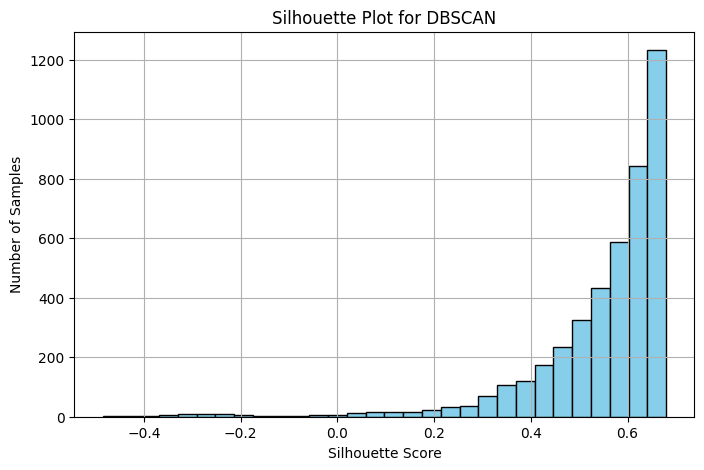

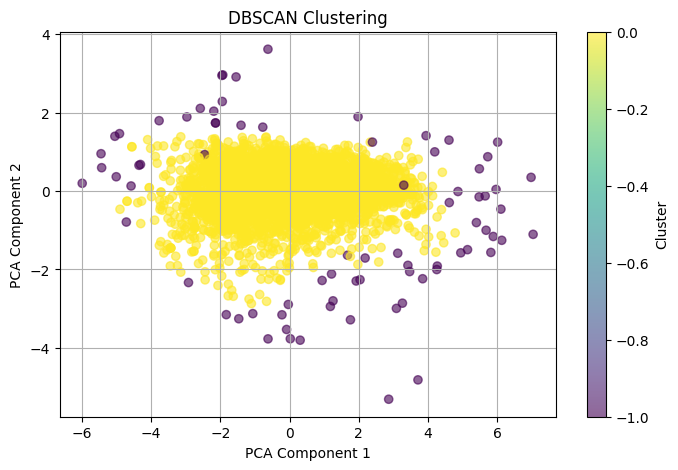

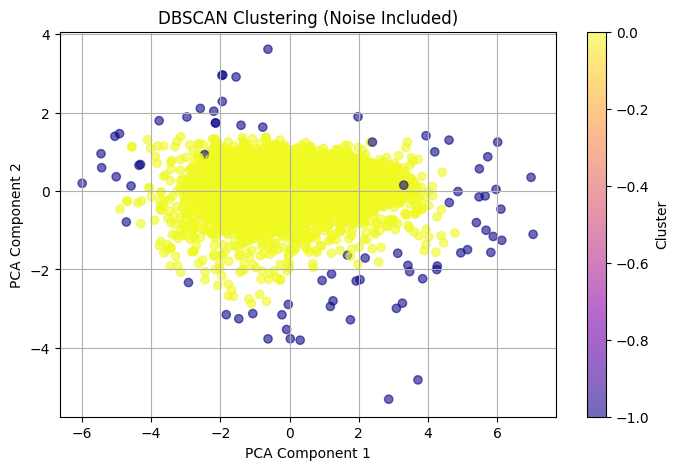

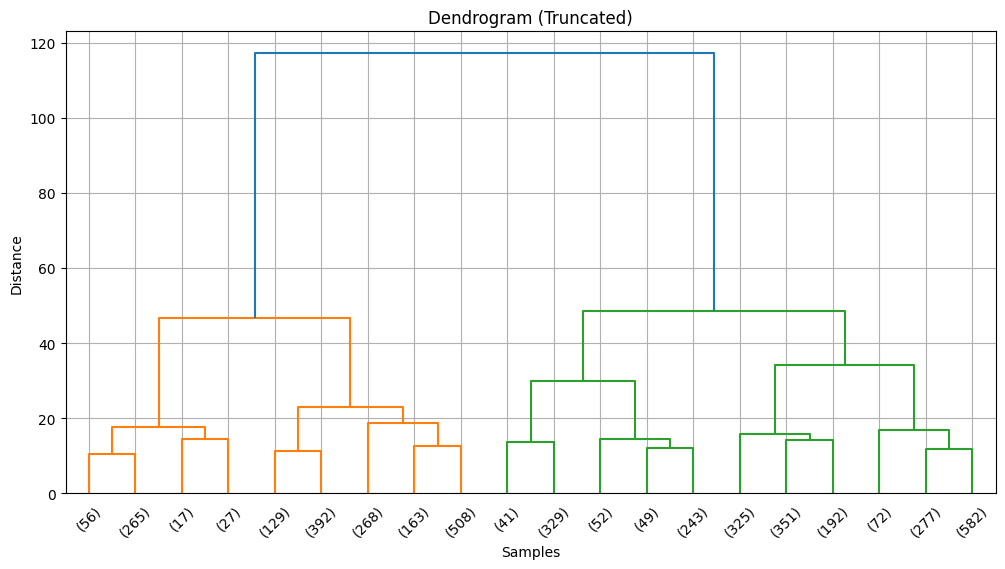

In [9]:
# Buat model DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps: jarak maksimum antara dua titik untuk dianggap sebagai tetangga
dbscan_labels = dbscan.fit_predict(X_scaled)

# Evaluasi Model
sil_score = silhouette_score(X_scaled, dbscan_labels)
db_score = davies_bouldin_score(X_scaled, dbscan_labels)
ch_score = calinski_harabasz_score(X_scaled, dbscan_labels)

print(f"DBSCAN Clustering:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# Visualisasi Silhouette Plot
from sklearn.metrics import silhouette_samples

# Calculate the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, dbscan_labels)

plt.figure(figsize=(8, 5))
plt.hist(sample_silhouette_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Silhouette Plot for DBSCAN")
plt.xlabel("Silhouette Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# Visualisasi Cluster Scatter Plot (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.title(f'DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Visualisasi Noise (-1) jika ada
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.6)
plt.title(f'DBSCAN Clustering (Noise Included)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#  Visualisasi Dendrogram
# Linkage matrix using ward method
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrogram (Truncated)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# Tambahkan label cluster ke dataframe
X_features['Cluster_DBSCAN'] = dbscan_labels

### **Penjelasan Model DBSCAN**

DBSCAN adalah algoritma density-based clustering yang bekerja dengan mengelompokkan titik-titik yang terdekat satu sama lain berdasarkan kerapatan data.

**Silhouette Score** (0.550):
Skor ini menunjukkan pemisahan klaster yang cukup baik. Semakin tinggi nilai ini (mendekati 1), semakin baik pemisahan antar klaster. Nilai 0.550 menunjukkan pemisahan klaster yang moderat, tetapi masih cukup baik.

**Davies-Bouldin Index** (3.977):
Nilai ini cukup tinggi. Semakin rendah nilai Davies-Bouldin, semakin baik pemisahan antar klaster. Nilai ini mengindikasikan bahwa klaster mungkin tidak terpisah dengan jelas, dengan adanya overlap antar klaster.

**Calinski-Harabasz Score** (48.594):
Semakin tinggi nilai ini, semakin baik pemisahan klaster. Nilai ini relatif rendah, yang menunjukkan bahwa klaster tidak terlalu terpisah dengan baik dibandingkan dengan model lain seperti KMeans atau Agglomerative Clustering.

> Matrik terbaik adalah Silhouette Score karena nilainya menunjukkan bahwa pemisahan klaster cukup baik, meskipun bisa lebih tinggi untuk hasil yang lebih optimal.

> DBSCAN belum tentu model terbaik, namun model ini kuat untuk menangani data dengan noise dan klaster tidak teratur, namun pemilihan parameter yang tepat sangat penting untuk kinerjanya.

# **Model Gaussian Mixture**

Gaussian Mixture Clustering:
Silhouette Score: 0.301
Davies-Bouldin Index: 2.625
Calinski-Harabasz Score: 1344.546


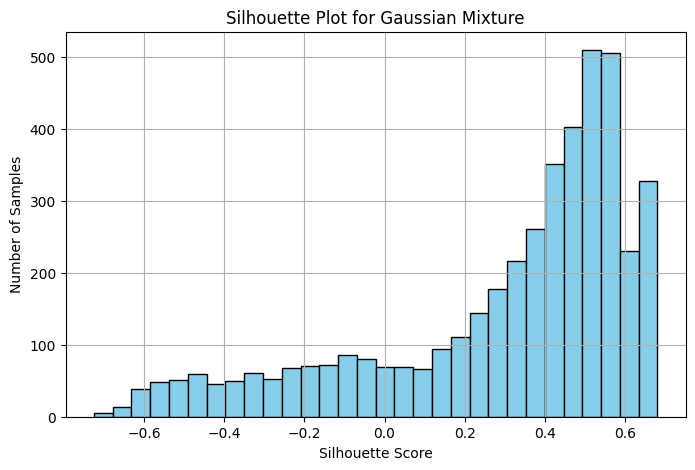

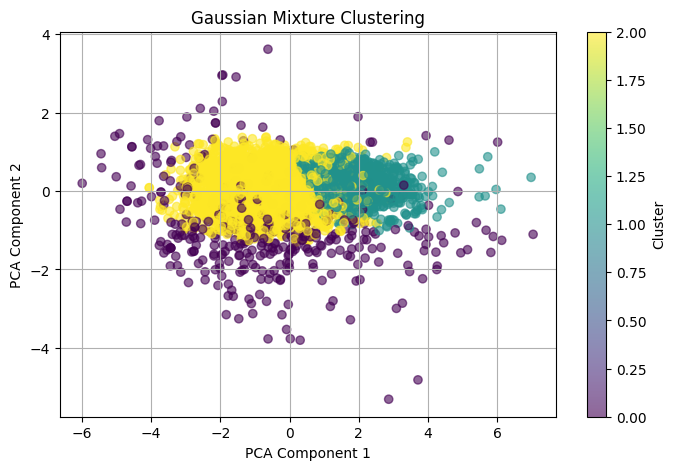

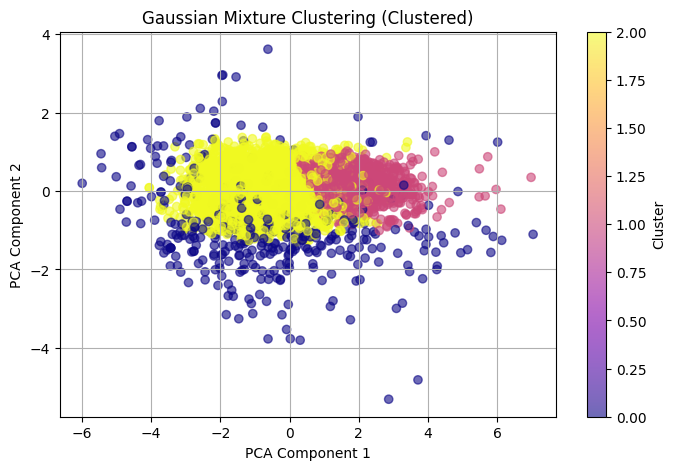

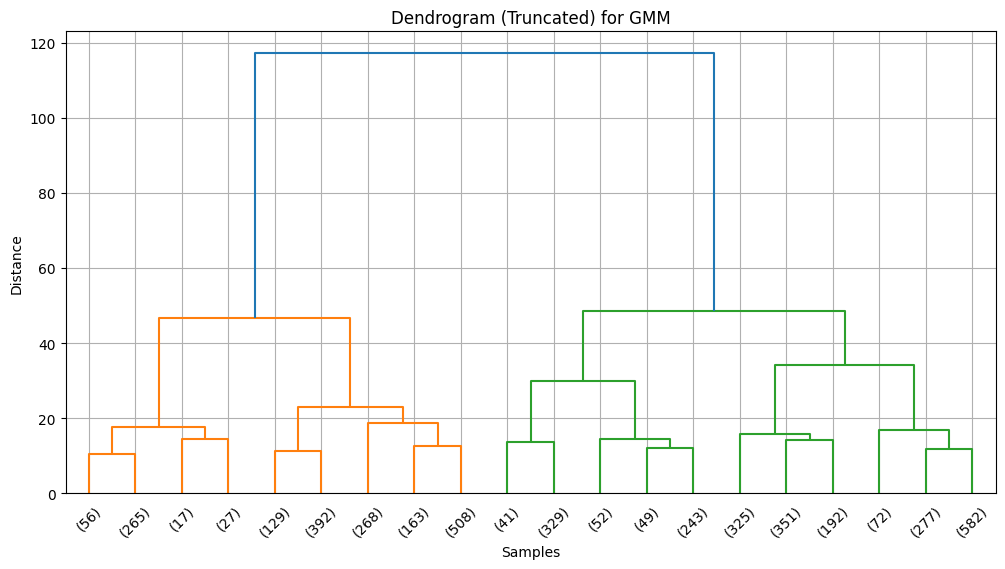

In [10]:
# 1. Buat model Gaussian Mixture
gmm = GaussianMixture(n_components=3, random_state=42)  # Menentukan jumlah klaster (komponen)
gmm_labels = gmm.fit_predict(X_scaled)

# 2. Evaluasi Model
sil_score = silhouette_score(X_scaled, gmm_labels)
db_score = davies_bouldin_score(X_scaled, gmm_labels)
ch_score = calinski_harabasz_score(X_scaled, gmm_labels)

print(f"Gaussian Mixture Clustering:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# 3. Visualisasi Silhouette Plot
sample_silhouette_values = silhouette_samples(X_scaled, gmm_labels)

plt.figure(figsize=(8, 5))
plt.hist(sample_silhouette_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Silhouette Plot for Gaussian Mixture")
plt.xlabel("Silhouette Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# 4. Visualisasi Cluster Scatter Plot (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
plt.title(f'Gaussian Mixture Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 5. Visualisasi Noise (jika ada)
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='plasma', alpha=0.6)
plt.title(f'Gaussian Mixture Clustering (Clustered)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 6. Visualisasi Dendrogram (untuk Hierarchical Clustering, walaupun GMM adalah model berbasis probabilitas)
# Linkage matrix menggunakan metode ward
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrogram (Truncated) for GMM")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# 7. Tambahkan label cluster ke dataframe
X_features['Cluster_GMM'] = gmm_labels

### **Penjelasan Model Gaussian Mixture**

Gaussian Mixture adalah model probabilitas yang menganggap data sebagai kombinasi dari beberapa distribusi Gaussianm Setiap Komponen Gaussian mewakili klaster dalam data.

**Silhouette Score** (0.301):
Silhouette score mengukur seberapa baik pemisahan klaster, dengan nilai yang lebih tinggi menunjukkan pemisahan yang lebih baik. Nilai 0.301 menunjukkan pemisahan klaster yang moderat, namun ada potensi untuk perbaikan.

**Davies-Bouldin Index** (2.625):
Davies-Bouldin index mengukur seberapa terpisah klaster yang dihasilkan, dengan nilai yang lebih rendah menunjukkan pemisahan yang lebih baik. Nilai 2.625 relatif tinggi, yang menunjukkan bahwa klaster yang dihasilkan tidak terpisah dengan sangat jelas.

**Calinski-Harabasz Score** (1344.546):
Skor ini mengukur pemisahan dan kepadatan klaster, dengan nilai yang lebih tinggi menunjukkan hasil yang lebih baik. Nilai ini tidak terlalu tinggi, yang menunjukkan bahwa klaster yang dihasilkan belum optimal.

Matrik terbaik adalah Silhouette Score meskipun masih rendah, namun ini yang terbaik di antara ketiganya, karena menunjukkan pemisahan klaster yang lebih baik dibandingkan dengan indeks Davies-Bouldin dan Calinski-Harabasz.

Model ini memili matriks evaluasi yang rendah, sehingga memungkinkan bukan model yang terbaik.

# **Model Spectral Clustering**

Spectral Clustering:
Silhouette Score: 0.380
Davies-Bouldin Index: 0.846
Calinski-Harabasz Score: 4528.636


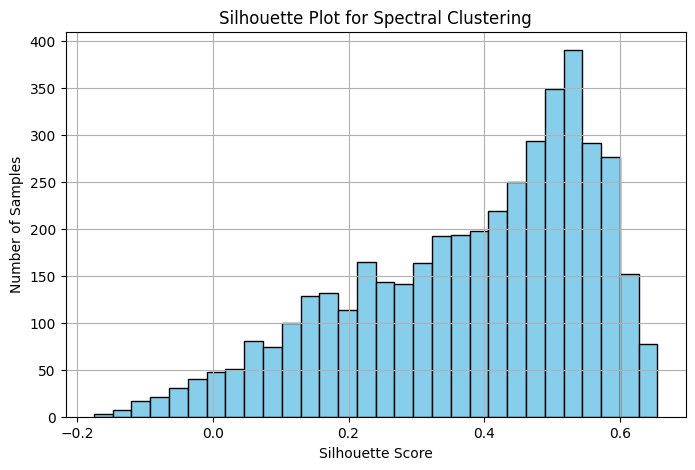

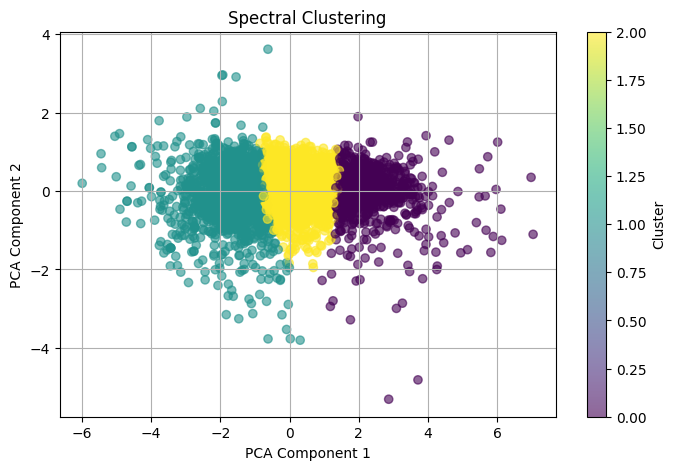

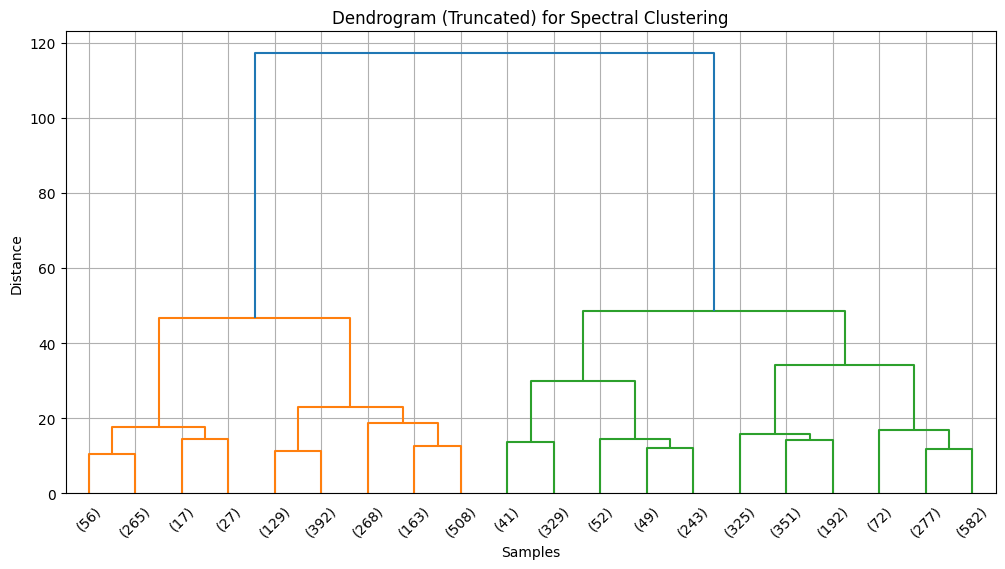

In [11]:
# 1. Buat model Spectral Clustering
spectral_model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_model.fit_predict(X_scaled)

# 2. Evaluasi Model
sil_score = silhouette_score(X_scaled, spectral_labels)
db_score = davies_bouldin_score(X_scaled, spectral_labels)
ch_score = calinski_harabasz_score(X_scaled, spectral_labels)

print(f"Spectral Clustering:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# 3. Visualisasi Silhouette Plot
sample_silhouette_values = silhouette_samples(X_scaled, spectral_labels)

plt.figure(figsize=(8, 5))
plt.hist(sample_silhouette_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Silhouette Plot for Spectral Clustering")
plt.xlabel("Silhouette Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# 4. Visualisasi Cluster Scatter Plot (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, cmap='viridis', alpha=0.6)
plt.title(f'Spectral Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 5. Visualisasi Dendrogram (untuk Hierarchical Clustering, walaupun Spectral Clustering bukan model hierarkis)
# Linkage matrix menggunakan metode ward
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrogram (Truncated) for Spectral Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# 6. Tambahkan label cluster ke dataframe
X_features['Cluster_Spectral'] = spectral_labels

### **Penjelasan Model SpectralClustering**

Spectral Clustering adalah model berbasis graf yang cocok untuk data yang klasternya tidak berbentuk bulat atau linear, seperti data kompleks yang sulit dipisah oleh metode biasa.

**Silhouette Score**: 0.380 — menunjukkan pemisahan antar klaster cukup baik, lebih tinggi dari GMM dan Agglomerative, setara dengan KMeans.

**Davies-Bouldin Index**: 0.846 — lebih rendah dari DBSCAN dan GMM, artinya pemisahan antar klaster relatif baik.

**Calinski-Harabasz Score**: 4528.636 — cukup tinggi, tapi masih kalah dari KMeans (4643).

matrik terbaik adalah Silhouette Score dan DB Index karena menjadi indikator kuat bahwa Spectral cukup baik dalam memisahkan klaster.